In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [101]:
class EWAlg:
    def __init__(self, epsilon, k, h, myBids, myValue):
        self.weights = np.ones(k)
        self.payoffs = np.zeros(k)
        self.h = h
        self.k = k
        self.epsilon = epsilon
        self.sumWeights = np.sum(self.weights)
        self.probs = self.weights/self.sumWeights
        self.myValue = myValue
        self.myBids = myBids
        self.myTotalValue = 0

    def getBids(self):
        return self.myBids

    def getValue(self):
        return self.myValue

    def getTotalValue(self):
        return self.myTotalValue

    def getAction(self):
        j = np.random.choice(self.k, 1, p = self.probs)
        return self.myBids[j.item()]
    
    def update(self, payoffs):
        for j in range(len(payoffs)):
            curPayoff = payoffs[j]
            self.payoffs[j] = self.payoffs[j] + curPayoff
            newWeight = (1+self.epsilon)**(self.payoffs[j]/self.h)
            self.weights[j] = newWeight
        self.sumWeights = np.sum(self.weights)
        self.weights = self.weights/self.sumWeights
        self.sumWeights = np.sum(self.weights)
        self.probs = self.weights/self.sumWeights
        return

    def generatePayoffs(self, bidToBeat, winningBid, meWin):
        if meWin:
            self.myTotalValue += self.myValue - winningBid
        payoffs = np.zeros(self.k)
        for count, bid in enumerate(self.myBids):
            if bid >= bidToBeat:
                payoffs[count] = self.myValue - bid
            else:
                payoffs[count] = 0
        return payoffs
    
    def reset(self):
        self.weights = np.ones(self.k)
        self.payoffs = np.zeros(self.k)
        self.sumWeights = np.sum(self.weights)
        self.probs = self.weights/self.sumWeights
        self.myTotalValue = 0


# Part 1 : Online Reserve Pricing

In [84]:
class Auction:
    def __init__(self, numItems, k = 100, h = 1, learningRate = 0.1):
        self.k = k
        self.numItems = numItems
        self.possibleReserves = np.linspace(0, h, k)
        self.learner = EWAlg(learningRate, k, h, self.possibleReserves, h)
        self.reserve = self.learner.getAction()

    def getReservePrices(self):
        return self.possibleReserves
    
    def setReservePrice(self, reserve):
        self.reserve = reserve
        return

    def getCurReservePrice(self):
        return self.reserve

    def getLearner(self):
        return self.learner

    def runAuction(self, bids):
        return self.runAuctionHelper(bids, self.numItems, self.reserve), self.reserve
    
    def runAuctionHelper(self, bids, numItemsToSell, reservePrice):
        bids.append(reservePrice)
        bids.sort()
        winningBids = []
        # check if highest bid is greater than reserve price
        if (bids[-(numItemsToSell)] > reservePrice):
            salePrice = bids[-(numItemsToSell+1)]
            for i in range(numItemsToSell):
                winningBids.append(bids[-(i+1)])
            saleRevenue = salePrice * numItemsToSell
            bids.remove(reservePrice)
            return saleRevenue
        else:
            bids.remove(reservePrice)
            numItemsToSell -= 1
            if numItemsToSell == 0:
                # cannot sell any, revenue is 0
                return 0
            return self.runAuctionHelper(bids, numItemsToSell, reservePrice)
        

    def generatePayoffs(self, bids):
        # calculate the payoff for a reserve valuee
        # repeat for all possible reserve values
        payoffs = np.zeros(self.k)
        for count, reserve in enumerate(self.possibleReserves):
            saleRevenue = self.runAuctionHelper(bids, self.numItems, reserve)
            payoffs[count] = saleRevenue
        return payoffs

    
    def updateReservePrice(self, bids):
        payoffs = self.generatePayoffs(bids)
        self.learner.update(payoffs)
        self.reserve = self.learner.getAction()
        return


In [85]:
class Bidders:
    def __init__(self, min, h):
        self.h = h
        self.min = min
    
    def getUniformValue(self):
        return random.uniform(self.min, self.h)
        

In [86]:
def runMultipleAuctions(auctionRounds = 1000, learningRate = 0.1):
    # create an auction and bidders
    auction = Auction(1, k = 100, h = 1, learningRate = learningRate)
    bidder1 = Bidders(0, 1)
    bidder2 = Bidders(0, 1)
    # things to keep track of
    allBids = []
    totalRevenue = 0
    avgRevenue = np.zeros(auctionRounds)
    reservePrices = np.zeros(auctionRounds)
    # run the auction
    for i in range(auctionRounds):
        v1 = bidder1.getUniformValue()
        v2 = bidder2.getUniformValue()
        bids = [v1, v2]
        allBids.append(bids)    
        curRevenue, reservePrices[i] = auction.runAuction(bids)
        totalRevenue += curRevenue
        avgRevenue[i] = totalRevenue/(i+1)
        auction.updateReservePrice(bids)
    return avgRevenue, reservePrices

In [87]:

def monteCarlo(MCRuns = 500, auctionRounds = 1000, learningRate = 0.1):
    finalReserves = []
    finalAvgRevenue = []
    reservesOverTime = []
    for i in range(MCRuns):
        avgRevenue, reservePrices = runMultipleAuctions(auctionRounds, learningRate)
        finalReserves.append(reservePrices[-1])
        finalAvgRevenue.append(avgRevenue[-1])
        reservesOverTime.append(reservePrices)
    return finalReserves, finalAvgRevenue, reservesOverTime

In [105]:
finalReserves = []
finalAvgRevenues = []
reservesOverTimes = []
epsilons = [0.0679, 0.1, 0.5, 2]
for epsilon in epsilons:
    finalReserve, finalAvgRevenue, reservesOverTime = monteCarlo(MCRuns = 500, auctionRounds = 1000, learningRate = epsilon)
    finalReserves.append(finalReserve)
    finalAvgRevenues.append(finalAvgRevenue)
    reservesOverTime = np.array(reservesOverTime)
    reservesOverTime = np.mean(reservesOverTime, axis = 0)
    reservesOverTimes.append(reservesOverTime)

In [ ]:
print(np.mean(finalReserves))
print(np.mean(finalAvgRevenue))

0.5023434343434344
0.4125434365652641
0.6111111111111112


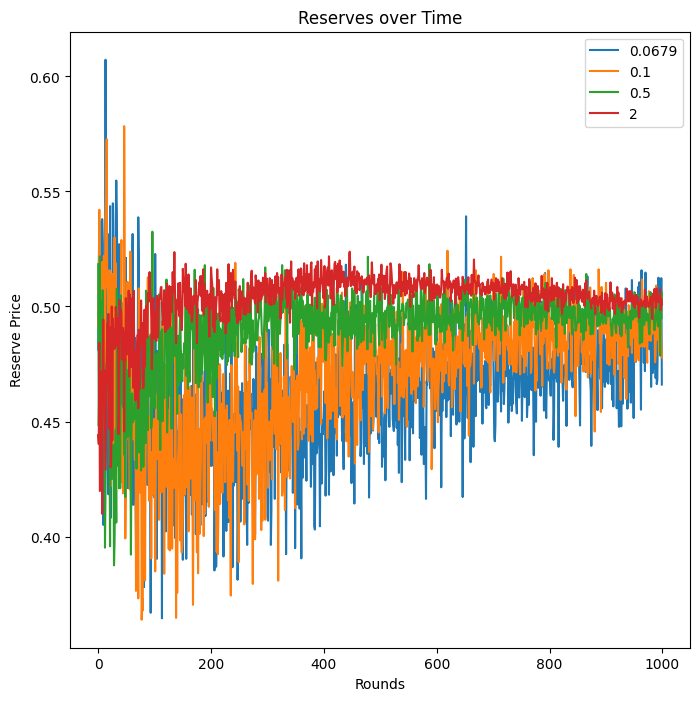

In [106]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(8)

for count, epsilon in enumerate(epsilons):
    plt.plot(np.arange(1000), reservesOverTimes[count], label = epsilon)

plt.title('Reserves over Time')
plt.xlabel('Rounds')
plt.ylabel('Reserve Price')
plt.legend()
plt.show()

In [ ]:
def findOptRev(numbidders, numItems):
    finalAvgRevenue = np.zeros(500)
    finalAvgReserve = np.zeros(500)
    for j in range(500):
        # create an auction and bidders
        auction = Auction(numItems, k = 100, h = 1, learningRate = 0.5)
        bidders = []
        for i in range(numbidders):
            bidders.append(Bidders(0, 1))
        totalRevenue = np.zeros(100)
        for i in range(1000):
            bids = []
            for bidder in bidders:
                bids.append(bidder.getUniformValue())
            possibleReserves = auction.getReservePrices()
            for count, reserve in enumerate(possibleReserves):
                auction.setReservePrice(reserve)
                payoffs, reserve = auction.runAuction(bids)
                totalRevenue[count] += np.max(payoffs)
        
        optReserve = possibleReserves[np.argmax(totalRevenue)]
        finalAvgReserve[j] = optReserve
        optRevenue = np.max(totalRevenue) / 1000
        finalAvgRevenue[j] = optRevenue
    return finalAvgReserve, finalAvgRevenue

In [ ]:
optReserve, optRevenue = findOptRev(4, 1)
finalOptReserve = np.mean(optReserve)
finalOptRevenue = np.mean(optRevenue)
print(finalOptReserve)
print(finalOptRevenue)

0.5034949494949496
0.6144866116272271


0.5016363636363637
0.4187566896366338
